In [49]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp

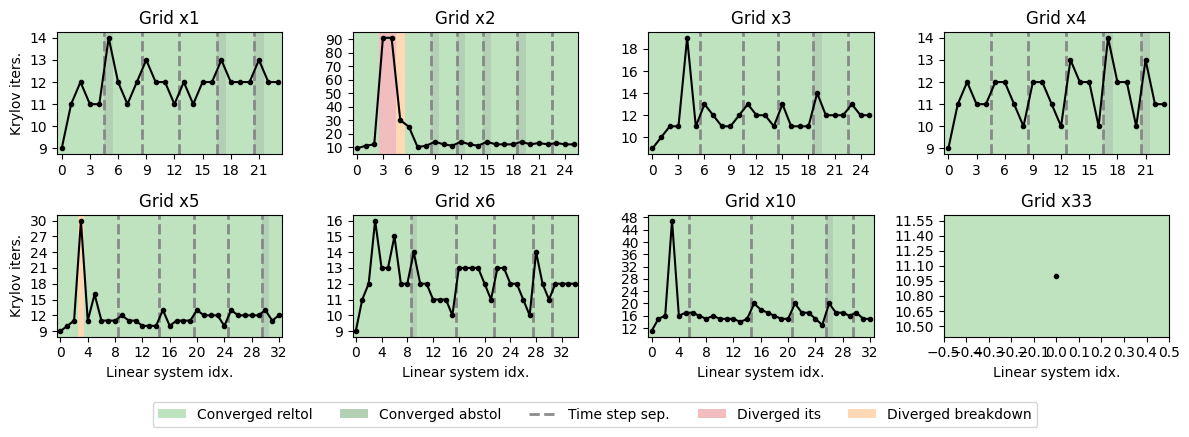

In [50]:
grid_refinement = [
    1,
    2,
    3,
    4,
    5,
    6,
    10,
    33,
]

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo0x{g}_sol{2}_ph{1}_bb{2}_fr{1}.json")
    names[i] = f"Grid x{g}"


shape = [2, 4]
figsize = (12, 4)


def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

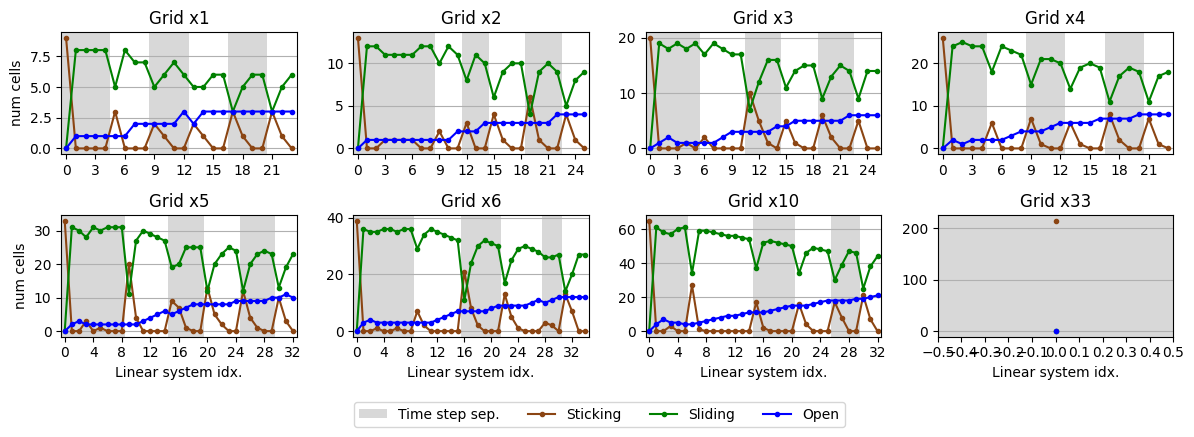

In [51]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [52]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mandel_runscript import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 0,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.0, Dt: 0.50 (days)
sticking: 9, sliding: 0, open: 0


In [53]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 1

IsADirectoryError: [Errno 21] Is a directory: '../matrices'

In [ ]:
2
)
model.linear_system = mat, rhs
model.bmat.mat = mat

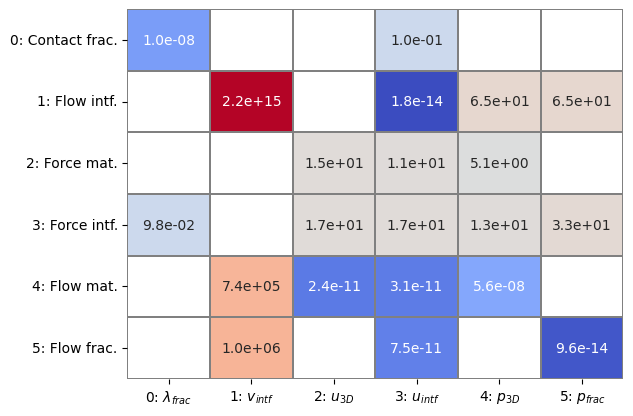

In [9]:
J = model.bmat[:]
J.plot_max()

Solve  took: 0.05
True residual: 7.340539631556922e-09
PETSc Converged Reason: 2


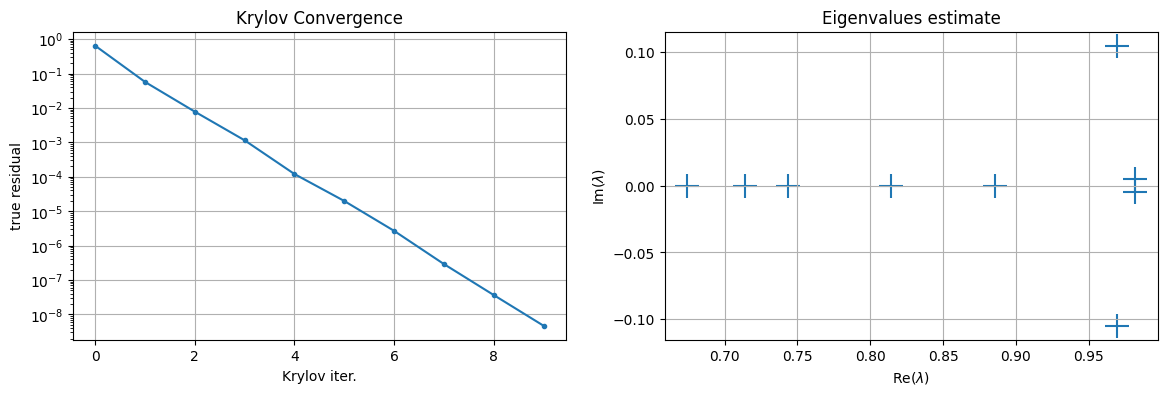

In [11]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat
                    # * 0,
                    # * 0.5,
                    * 1,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

all: 11
none: 16
only_mat: 11
only_frac: 16

Solve  took: 0.23
True residual: 1.2457693417389754e-14
PETSc Converged Reason: 2
Error in callback <function _draw_all_if_interactive at 0x761a70380ae0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

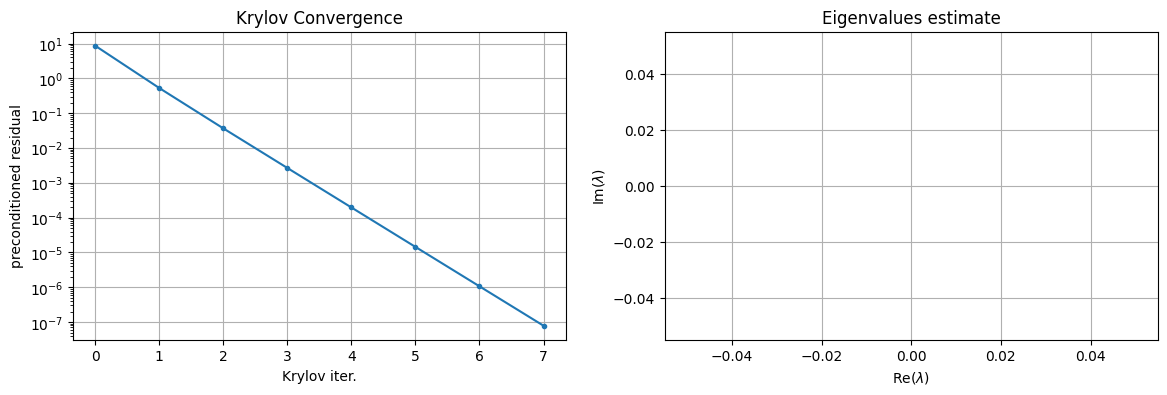

In [13]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        # right_transformations=[
        #     lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        # ],
        preconditioner=FieldSplitScheme(
            # Exactly solve elasticity and contact mechanics, build fixed stress.
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat * 1,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)

Solve  took: 0.47
True residual: 1.2595284410140698e-14
PETSc Converged Reason: 2


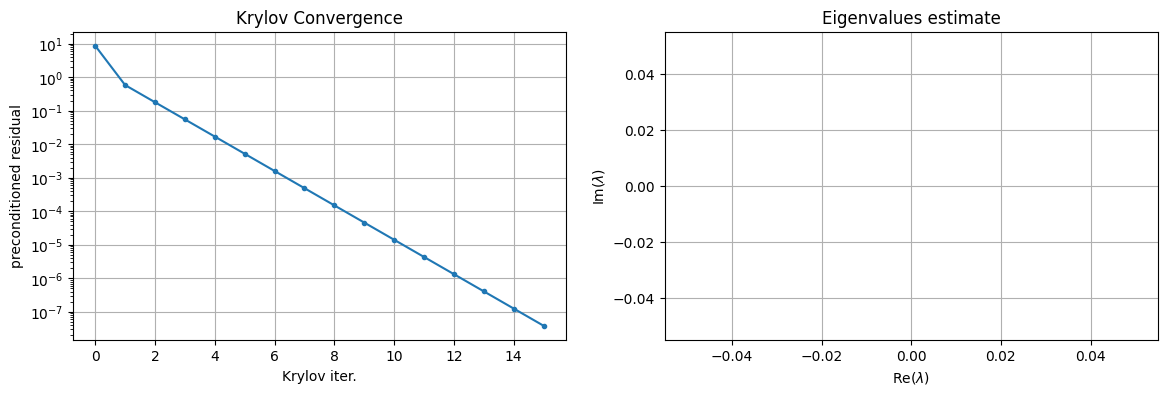

In [14]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            # Exactly solve elasticity and contact mechanics, build fixed stress.
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat * 0,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)

Solve  took: 0.1
True residual: 4.296768917815867e-08
PETSc Converged Reason: 2


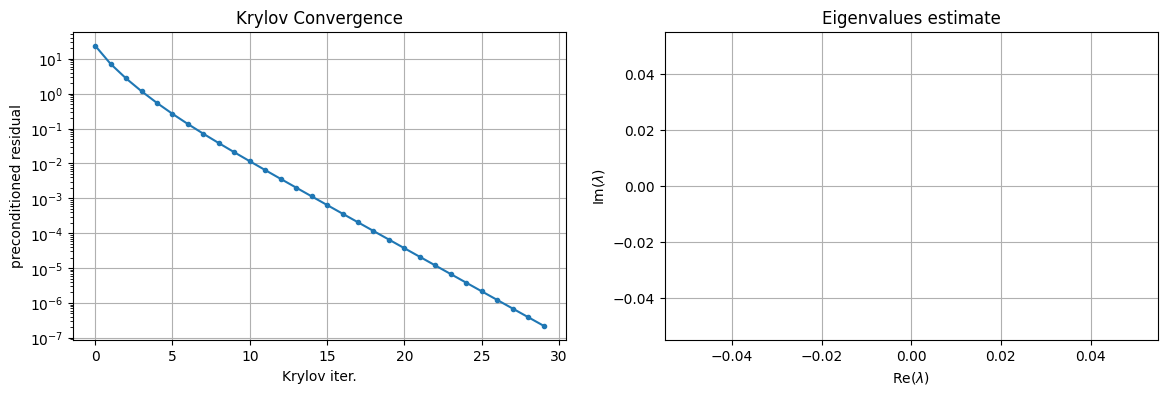

In [15]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        preconditioner=FieldSplitScheme(
            groups=[2, 3],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2,3]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model, include_intf=True),
            ),
        ),
    ),
)

In [89]:
pc = PetscAMGMechanics(
    mat=J[[2, 3]].mat,
    dim=model.nd,
    null_space=build_mechanics_near_null_space(model, include_intf=True),
)
pc.pc.view()

PC Object: 1 MPI process
  type: gamg
    type is MULTIPLICATIVE, levels=5 cycles=v
      Cycles per PCApply=1
      Using externally compute Galerkin coarse grid matrices
      GAMG specific options
        Threshold for dropping small values in graph on each level =   0.11   0.11   0.11   0.11   0.11  
        Threshold scaling factor for each level not specified = 1.
        AGG specific options
          Number of levels of aggressive coarsening 1
          Square graph aggressive coarsening
          Number smoothing steps 3
        Complexity:    grid = 1.41839    operator = 5.05832
  Coarse grid solver -- level 0 -------------------------------
    KSP Object: (mg_coarse_) 1 MPI process
      type: preonly
      maximum iterations=10000, initial guess is zero
      tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
      left preconditioning
      using NONE norm type for convergence test
    PC Object: (mg_coarse_) 1 MPI process
      type: bjacobi
        number of